<a href="https://colab.research.google.com/github/PadmajaVB/Sexist-Statement-Detection/blob/main/SexistCommentDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install tensorflow-addons

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 7.6MB/s 


In [4]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split
import re
import collections

import tensorflow_addons as tfa
from keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential,model_from_json, load_model
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Embedding, Dense, Flatten, RepeatVector, Permute, Activation, Dropout, Bidirectional, Multiply, Lambda

## Loading data

In [5]:
data_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/ISEP Sexist Data labeling.xlsx'
data  = pd.read_excel(data_path)

In [6]:
data.head()

,Sentences,Label
0,"For a woman, that is good",1
1,Just dress sexy and you will sign any contract.,1
2,Are you having period ?,1
3,Stop being bitchy,1
4,I leave early because of her children instead ...,1


In [7]:
def clean_data(df):
  df.Sentences = [element.lower() for element in df.Sentences]
  df.Sentences = [re.sub(r'[^a-zA-Z /n]', '', element) for element in df.Sentences]
  # df.Sentences = ['<s> '+ element + ' </s>' for element in df.Sentences]
  return df

In [8]:
df = clean_data(data)

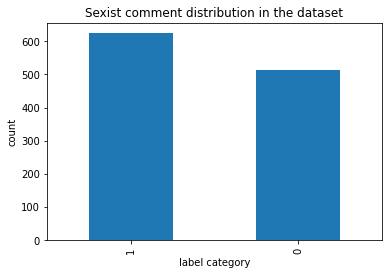

In [9]:
df['Label'].value_counts().plot(kind='bar')
plt.xlabel('label category')
plt.ylabel('count')
plt.title('Sexist comment distribution in the dataset')
plt.show()

## Train-test split

In [10]:
X = df[['Sentences']]
y = df.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 66, stratify=y)

In [11]:
#!unzip '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-GNGloVe-300d-0.8-0.8.zip' -d '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/'

### Loading the Gender neutral GLoVe embedding

In [12]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [13]:
embedding_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-vectors300-0.8-0.8.txt'
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs(embedding_path)

In [14]:
word_to_vec_map['and'].shape

(300,)

In [15]:
vocab = list(words_to_index.keys())

In [16]:
len(vocab)

142527

### Getting word embeddigs for the input data - X_train and X_test

In [17]:
def get_tokens_embedding_list(data, vocab, word_to_vec_map):
  embedding_list = []
  for sent_seq in data:
    tensor_list=[]
    for word in sent_seq[0].split():
      if word in vocab:
        tensor_list.append(word_to_vec_map[word])
        # print(len(tensor_list))
    embedding_list.append(tensor_list)
  return embedding_list

In [18]:
X_train_embedding = get_tokens_embedding_list(X_train.values, vocab, word_to_vec_map)
X_test_embedding = get_tokens_embedding_list(X_test.values, vocab, word_to_vec_map)

In [19]:
X_train, X_val, y_train, y_val = train_test_split(X_train_embedding, y_train, train_size=0.9, random_state=66)

In [20]:
len(X_train_embedding), len(X_train), len(X_test_embedding)

(909, 818, 228)

In [21]:
np.array(X_train[0]).shape

(15, 300)

In [22]:
def create_dataset(data_in, target_in):
   
    #Get the length of each sentence
    N = [len(data_in[i]) for i, _ in enumerate(data_in)]
    embedding_size = 300
    tensor_N = tf.constant(N, tf.int32)
    ragged_input  = tf.ragged.constant(data_in, dtype=tf.float32)
    print(ragged_input.shape)

    # Build the dataset and the operations
    dataset = tf.data.Dataset.from_tensor_slices((ragged_input, target_in))
    del ragged_input

    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(32)
    
    # Transform_pad function is defined above; you can change the num_parallel_calls
    dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None, embedding_size]), y), num_parallel_calls=3)   
                          
    dataset = dataset.prefetch(1)
    return dataset

In [23]:
train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val)

(818, None, None)
(91, None, None)


In [24]:
train_dataset

<PrefetchDataset shapes: ((None, None, 300), (None,)), types: (tf.float32, tf.int64)>

### Define the model

In [25]:
input_layer = Input((None, 300), name='input')
bid_lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
dropout_1 = Dropout(0.5)(bid_lstm_1)
bid_lstm_2 = Bidirectional(LSTM(128, return_sequences=False))(dropout_1)
dropout_2 = Dropout(0.5)(bid_lstm_2)
dense = Dense(1, activation='sigmoid')(dropout_2)

model = Model(inputs=input_layer, outputs=dense)

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 300)]       0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 256)         439296    
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 833,793
Trainable params: 833,793
Non-trainable params: 0
_______________________________________________________

In [27]:
model.compile(optimizer='adam', loss='bce', metrics=tfa.metrics.F1Score(num_classes=2, average='micro'))

In [28]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, verbose=1)

In [29]:
ragged_input_test  = tf.ragged.constant(X_test_embedding, dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((ragged_input_test, y_test))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(1)
test_dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None, 300]),y), num_parallel_calls=3)


In [30]:
loss, f_score = model.evaluate(test_dataset)

228/228 [==============================] - 8s 5ms/step - loss: 0.6960 - f1_score: 0.7082


## Model with attention

In [31]:
input_layer = Input((None, 300), name='input')
bid_lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
dropout_1 = Dropout(0.5)(bid_lstm_1)

attention = Dense(1, activation='tanh')(dropout_1)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(128 * 2)(attention)
attention = Permute([2, 1])(attention)

sent_representation = Multiply()([dropout_1, attention])
sent_representation = Lambda(lambda xin: K.sum(xin, axis=1))(sent_representation)

dropout_2 = Dropout(0.5)(sent_representation)
dense = Dense(1, activation='sigmoid')(dropout_2)

model = Model(inputs=input_layer, outputs=dense)

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, 300)]  0                                            
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, None, 256)    439296      input[0][0]                      
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, None, 256)    0           bidirectional_2[0][0]            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, None, 1)      257         dropout_2[0][0]                  
____________________________________________________________________________________________

In [33]:
model.compile(optimizer='adam', loss='bce', metrics=tfa.metrics.F1Score(num_classes=2, average='micro'))

In [34]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, verbose=1)

Epoch 1/10
23/26 [=========================>....] - ETA: 0s - loss: 0.6141 - f1_score: 0.7054

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


26/26 [==============================] - 4s 36ms/step - loss: 0.6106 - f1_score: 0.7077 - val_loss: 0.6082 - val_f1_score: 0.7183
Epoch 2/10
26/26 [==============================] - 0s 11ms/step - loss: 0.4463 - f1_score: 0.7077 - val_loss: 0.4749 - val_f1_score: 0.7183
Epoch 3/10
26/26 [==============================] - 0s 12ms/step - loss: 0.3674 - f1_score: 0.7077 - val_loss: 0.4826 - val_f1_score: 0.7183
Epoch 4/10
26/26 [==============================] - 0s 11ms/step - loss: 0.3289 - f1_score: 0.7077 - val_loss: 0.4868 - val_f1_score: 0.7183
Epoch 5/10
26/26 [==============================] - 0s 11ms/step - loss: 0.2922 - f1_score: 0.7077 - val_loss: 0.3810 - val_f1_score: 0.7183
Epoch 6/10
26/26 [==============================] - 0s 11ms/step - loss: 0.2801 - f1_score: 0.7077 - val_loss: 0.3994 - val_f1_score: 0.7183
Epoch 7/10
26/26 [==============================] - 0s 12ms/step - loss: 0.2380 - f1_score: 0.7077 - val_loss: 0.4469 - val_f1_score: 0.7183
Epoch 8/10
26/26 [======

### Script to get the data for everyday Sexism project

In [35]:
!pip install ipdb

     |████████████████████████████████| 788kB 9.8MB/s 
     |████████████████████████████████| 368kB 21.9MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.8-cp37-none-any.whl size=11599 sha256=d839fd73980ff3fe86fe9f9ed5af4b3dc5f8d906d28d4410b1267be7ab091db3
  Stored in directory: /root/.cache/pip/wheels/0d/d6/5a/2fdf30b75ca5099e18f66a0a4d439ba031e1aa239e12b39c24
Successfully built ipdb
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.18 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.23.1 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0


In [36]:
!apt-get install libmagic-dev
!pip install python-magic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1
Suggested packages:
  file
The following NEW packages will be installed:
  libmagic-dev libmagic-mgc libmagic1
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 332 kB of archives.
After this operation, 5,552 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-mgc amd64 1:5.32-2ubuntu0.4 [184 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic1 amd64 1:5.32-2ubuntu0.4 [68.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-dev amd64 1:5.32-2ubuntu0.4 [79.7 kB]
Fetched 332 kB in 1s (227 kB/s)
Selecting previously unselected package libmagic-m

In [37]:
!pip install ftfy

     |████████████████████████████████| 71kB 5.6MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41916 sha256=716904f52b70aaf841cf383a11fe4f203a4e08021cda22b0b21c2ad60ba7f1fe
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ftfy


In [ ]:
# Example use: python script.py data_placeholders.tsv data.tsv
import re
import urllib.request as urllib2
import os
import ipdb
from bs4 import BeautifulSoup
import time
import sys
import codecs
import pandas as pd
import csv
import json
from os import listdir
from os.path import isfile, join
import io
import magic
import pickle
import ftfy

tsv_filepath = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/Everyday Sexism Project/data_placeholders.tsv'
data_write_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/Everyday Sexism Project/data.tsv'


def find_post_id(name_box):
    classes = name_box['class']
    for _class in classes:
        if _class[:5] == "post-" and len(_class) > 5:
            return int(_class[5:])
    return -1


def crawl_post(post_page, post_number):
    crawl_page = post_page + str(post_number)

    isCrawledSuccessfully = False
    while not isCrawledSuccessfully:
        try:
            page = urllib2.urlopen(crawl_page).read()
            isCrawledSuccessfully = True
        except urllib2.HTTPError as e:
            if e.code == 404:
                print("\t\t>>> Found 404")
                return None
            else:
                print("\t\t>>> Waitiing for 30 seconds")
                time.sleep(30)
        except Exception:
            print("\t\t>>> Waitiing for 30 seconds")
            time.sleep(30)

    soup = BeautifulSoup(page, 'html.parser')
    name_boxes = soup.find_all('article', attrs={'class': 'post'})
    assert len(name_boxes) == 1
    for i, name_box in enumerate(name_boxes):
        post_id = find_post_id(name_box)
        if post_id == -1:
            print("\t\t>>> ERROR: Error fetching post_id")
            return None
        
        #TODO: VERIFY IF THIS IS CORRECT
        soup = BeautifulSoup(name_box.encode("utf-8"), 'html.parser')
        _name_box = soup.find('div', attrs={'class': 'entry-content'})
        post = _name_box.get_text()
        post = post.replace('\n', '<br/>')
    return post


import re

r_white = re.compile(r'\s+')

xml_csv = open(data_write_path, 'w')
csv_writer = csv.writer(xml_csv, delimiter='\t')
csv_writer.writerow(['post', 'labels'])

post_id_dict = {}

with open(tsv_filepath, 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\t')
    for i, row in enumerate(spamreader):
        if i == 0:
            continue
        labels = row[1]
        parts = row[0].split("__")
        post_id__str = parts[0]
        post_offsets__str = [offset.split("_") for offset in parts[1:]]

        if post_id__str in post_id_dict:
            print("accessing " + post_id__str)
            post_text = post_id_dict[post_id__str]
        else:
            print("fetching " + post_id__str)
            post_text = crawl_post("https://everydaysexism.com/everyday-sexism/", post_id__str)
            if post_text == None:
                continue
            post_id_dict[post_id__str] = post_text

        post_text = post_text.replace('<br/>', ' ')
        post_text = re.sub(' +', ' ', post_text)
        post_text = post_text.lstrip()
        post_text__fixed = ftfy.fix_text(post_text)
        text = ""
        for index in range(len(post_offsets__str)):
            text = text + post_text__fixed[int(post_offsets__str[index][0]):int(post_offsets__str[index][1]) + 1]
            if len(post_offsets__str) > 1 and len(post_offsets__str) != index + 1:
                text = text + " "
        text = r_white.sub(' ', text)
        text = text.strip()
        csv_writer.writerow([text, labels])

xml_csv.close()

In [ ]:
df_es = pd.read_csv(data_write_path, sep='\t')